# CS452 Assignment 3: Image Compression by K-Means Clustering

In [1]:
# Author: Göksel Can Önal
# Department: Computer Science
# Degree: BSc.

In [2]:
# Imports library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2 as cv
from PIL import Image, ImageColor
import webcolors

## Image Loading

In [3]:
# load images
baboon = cv.imread("baboon.png")
flowers = cv.imread("flowers.png")
graffiti = cv.imread("graffiti.jpg")
lena = cv.imread("lena.png")
umbrella = cv.imread("umbrella.jpg")
images = [baboon, flowers, graffiti, lena, umbrella]
images_titles = ["Baboon", "Flowers", "Graffiti", "Lena", "Umbrella"]
images_paths = ["baboon.png", "flowers.png", "graffiti.jpg", "lena.png", "umbrella.jpg"]

In [4]:
# Image shapes
k = 0
print("Shape of images:")
for img in images:
    print("\t\t", images_titles[k], "->", img.shape)
    k += 1

Shape of images:
		 Baboon -> (512, 512, 3)
		 Flowers -> (512, 512, 3)
		 Graffiti -> (2048, 2048, 3)
		 Lena -> (512, 512, 3)
		 Umbrella -> (1024, 1024, 3)


In [5]:
# Plots image
def plt_img(image, title, k):
    plt.subplot(1, len(images), k)
    plt.axis("off")
    plt.title(title)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

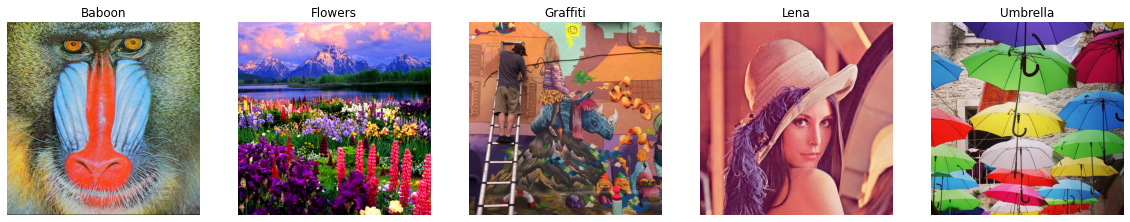

In [6]:
# Shows images
plt.figure(figsize=(20,10))
for i in range(len(images)):
    plt_img(images[i], images_titles[i], i+1)
plt.savefig("all_images.png")
plt.show()

## Image Preprocessing

In [7]:
# Resizes image to 256x256x3
# Reshapes images to 2D
images_prep = list()
for img in images:
    img_resized = cv.resize(img, (256,256))
    img_resized.shape = (img_resized.shape[0] * img_resized.shape[1], 3)
    images_prep.append(img_resized)

In [8]:
# Bytes of images
print("Bytes of original images:")
for i in range(len(images_paths)):
    image_file = Image.open(images_paths[i])
    print("\t\t",images_titles[i], "->", str(len(image_file.fp.read())),"Bytes")

Bytes of original images:
		 Baboon -> 648010 Bytes
		 Flowers -> 614992 Bytes
		 Graffiti -> 1074472 Bytes
		 Lena -> 473777 Bytes
		 Umbrella -> 278455 Bytes


In [9]:
print("Bytes of original images after preprocessing:")
for i in range(len(images_prep)):
    img_encode = cv.imencode('.png', images_prep[i])[1]
    data_encode = np.array(img_encode)
    byte_encode = data_encode.tobytes()
    print("\t\t",images_titles[i], "->",len(byte_encode))

Bytes of original images after preprocessing:
		 Baboon -> 214504
		 Flowers -> 214162
		 Graffiti -> 203213
		 Lena -> 210357
		 Umbrella -> 210397


In [10]:
# Number of unique colors
print("# of unique colors:")
for i in range(len(images_prep)):
    print("\t\t",images_titles[i],"->",len(np.unique(images_prep[i], axis=0)))

# of unique colors:
		 Baboon -> 62070
		 Flowers -> 57848
		 Graffiti -> 47091
		 Lena -> 48331
		 Umbrella -> 49461


## Metrics

In [11]:
# Prepares dataframes for error functions
def prepare_dfs(data, labels, cluster_centers):
    image = pd.DataFrame(data=data, columns=["B", "G", "R"])
    label = pd.DataFrame(data=labels, columns=["label"])
    labeled_image = pd.concat([image,label], axis=1)

    final_df = pd.DataFrame(data=[], columns=["B", "G", "R"])
    for i in range(cluster_centers.shape[0]):
        new_df = (cluster_centers[i] - labeled_image[labeled_image["label"] == i].iloc[:,:-1])**2
        final_df = pd.concat([final_df, new_df], axis=0)
        
    return (labeled_image, final_df)

In [12]:
# Within Cluster Sum of Squares
def wcss(data, labels, cluster_centers):
    labeled_image, final_df = prepare_dfs(data, labels, cluster_centers)
    tot_distance = final_df.sum().sum()
     
    return round(tot_distance,3)

In [13]:
# Between Cluster Sum of Squares
def bcss(data, labels, cluster_centers):
    labeled_image, final_df = prepare_dfs(data, labels, cluster_centers)
    
    lengths = []
    for i in range(cluster_centers.shape[0]):
        new_df = labeled_image[labeled_image["label"] == i].iloc[:,:-1]
        lengths.append(new_df.shape[0])
        
    mean = np.mean(labeled_image[["B","G","R"]], axis=0)
    distances = (np.linalg.norm(np.array(mean) - cluster_centers, axis=1)**2) * lengths
    
    return  round(distances.sum(), 3)

In [14]:
# finds closest cluster using given cluster for Silhouette Coefficients
def closest_cluster(label, cluster_centers):
    distances = np.linalg.norm(cluster_centers[label] - cluster_centers,axis=1)
    closest_label = np.where(distances == np.sort(distances)[1]) 
    
    return closest_label[0][0]

In [15]:
def silhouette_helper(data, labels, cluster_centers):
    labeled_image, final_df = prepare_dfs(data, labels, cluster_centers)
    frame_list = []
    for label in range(cluster_centers.shape[0]):
        df_label = labeled_image[labeled_image["label"] == label]
        df_label.reset_index(drop=True, inplace=True)
        frame_list.append(df_label)
    return frame_list

In [16]:
# Explained Variance(Silhouette)
def silhouette(data, labels, cluster_centers):
    labeled_image, final_df = prepare_dfs(data, labels, cluster_centers)
    cluster_frames = silhouette_helper(data, labels, cluster_centers)
    
    scores = []
    # takes all instaces one by one
    for instance in range(labeled_image.shape[0]):
        
        # creates a dataframe with data which have the same label of current instance
        label = labeled_image["label"][instance]
        df_label = cluster_frames[label]
        
        # keeps current instace
        current_instance = labeled_image.loc[instance][:3]
        
        # calculates average distance between current instance and all other points in the same cluster
        avg_dist = np.linalg.norm((current_instance - df_label[["B","G","R"]]), axis=1).sum() / df_label.shape[0]
        
        # takes next closest cluster for cluster of current instance
        closest_label = closest_cluster(label,cluster_centers)
        df_label_closest = cluster_frames[closest_label]
        
        # calculates average distance between current instance and all other points in the next nearest cluster
        avg_dist_closest = np.linalg.norm((current_instance - df_label_closest[["B","G","R"]]), axis=1).sum() / df_label_closest.shape[0]

        silhouette = (avg_dist_closest - avg_dist) / max(avg_dist_closest, avg_dist)
        scores.append(silhouette)
        
    return round(sum(scores) / len(scores), 3)

In [17]:
# according to the given rgb, finds closest color from webcolors 
def closest_color(rgb):
    color_diffs = []
    for color in webcolors.CSS3_HEX_TO_NAMES:
        color_diff2 = np.linalg.norm(rgb - ImageColor.getcolor(color, "RGB"))
        color_diffs.append((color_diff2, color))
    return webcolors.hex_to_name(min(color_diffs)[1])

In [18]:
# plots elbow curve
def elbow(wcss, ks, k, title, optimum=None):
    plt.subplot(1, len(images), k)
    plt.plot(ks,wcss, linewidth=3)
    if optimum != None:
        plt.scatter(optimum, wcss[optimum-1], s=200, c="red")
    plt.title(f"{title}")
    plt.xticks(ks)
    plt.savefig(f"elbow_{k}.png")

In [19]:
# plots silhouette scores
def exp_variance(exp_v, ks, k, title):
    plt.subplot(1, len(images), k)
    plt.plot(ks,exp_v, linewidth=3)
    plt.title("Silhouette" + f" ({title})")
    plt.xticks(ks)
    plt.savefig(f"silhouette_{k}.png")

## KMeans Clustering

In [20]:
# k values
ks = np.arange(8,0,-1)


 BABOON


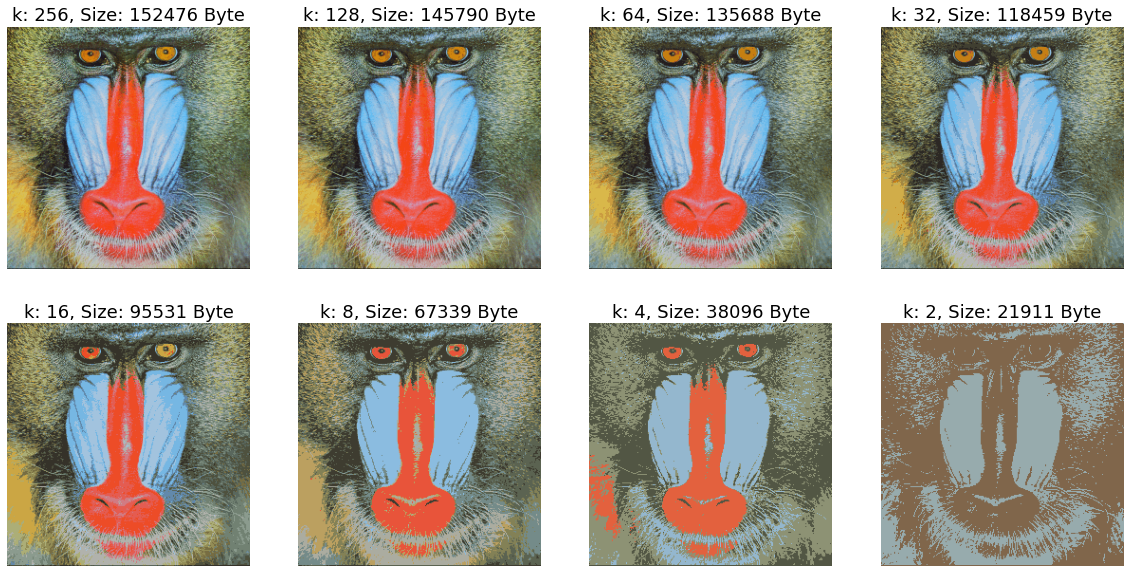

	----------------------------------------------------------------------------------------------------

 FLOWERS


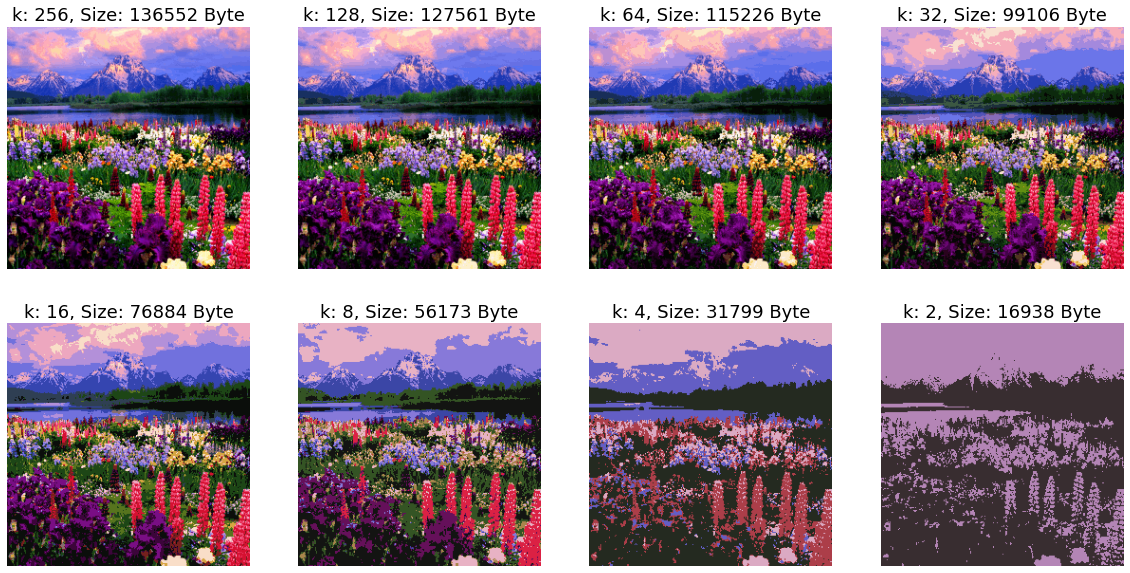

	----------------------------------------------------------------------------------------------------

 GRAFFITI


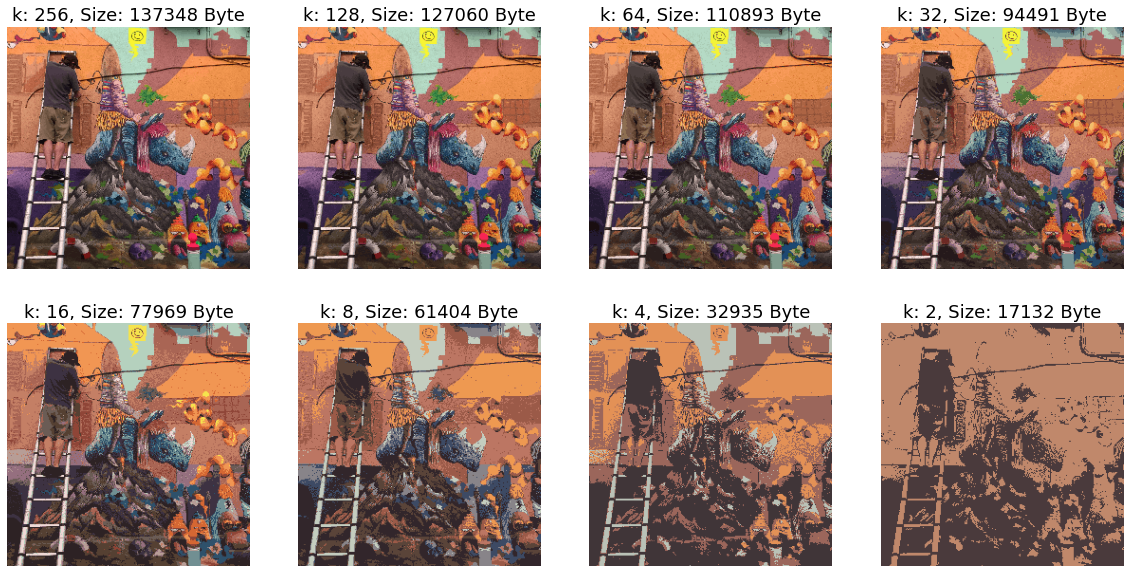

	----------------------------------------------------------------------------------------------------

 LENA


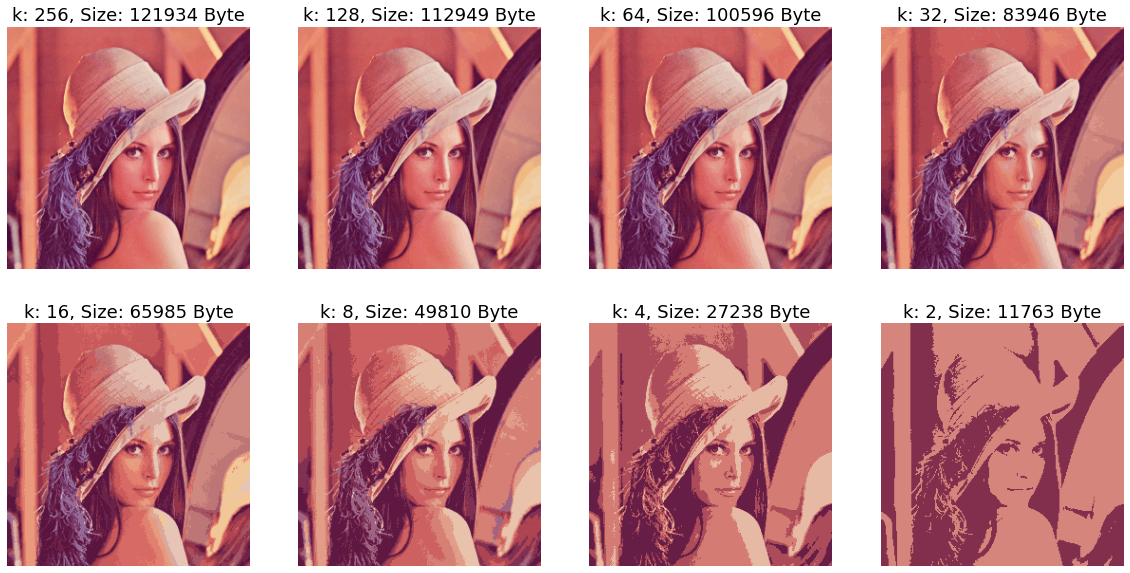

	----------------------------------------------------------------------------------------------------

 UMBRELLA


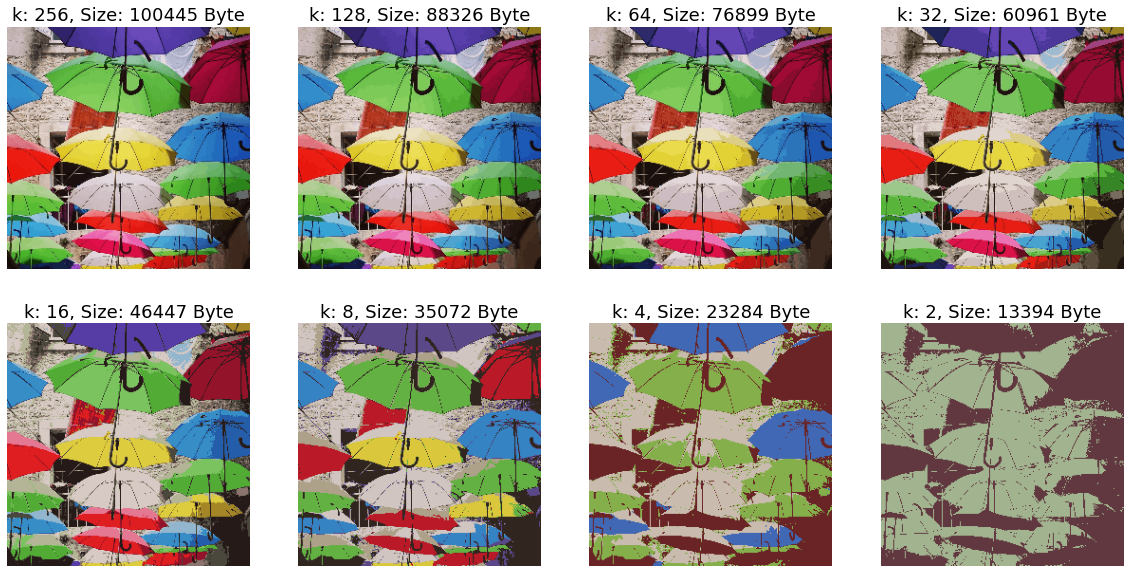

	----------------------------------------------------------------------------------------------------


k           WCSS            BCSS    Byte  \
Name                                                   
Baboon    256    4721707.755   529511813.711  152476   
Baboon    128    7450981.901    526822196.32  145790   
Baboon     64   11779396.972   522427166.041  135688   
Baboon     32   19387337.013   514735532.689  118459   
Baboon     16   34249384.006   500280364.365   95531   
Baboon      8   63295224.459   470789362.415   67339   
Baboon      4  123314156.507    410807823.23   38096   
Baboon      2  303681959.468   230846856.905   21911   
Flowers   256     9313285.97  1135207107.411  136552   
Flowers   128   15310337.663  1129181699.723  127561   
Flowers    64   25223194.684  1119062279.861  115226   
Flowers    32   42550603.065  1102053587.308   99106   
Flowers    16   75691894.214  1068334810.179   76884   
Flowers     8  139466564.706  1005327972.588   56173   
Flowers     4  257561121.151   887491256.196   31799   
Flowers     2  488348789.764    656369317.34   16938   
Graffiti  256    3981505.734     589533745.5  137348   
Graffiti  128    6727992.356    586781425.05  127060   
Graffiti   64   11823578.015   581556503.425  110893   
Graffiti   32   21494411.611   572079261.736   94491   
Graffiti   16   38467645.275   555229001.388   77969   
Graffiti    8   64776200.961   528953976.922   61404   
Graffiti    4  115467864.755   478009470.606   32935   
Graffiti    2  233127164.112   360378390.925   17132   
Lena      256    1492965.913   405583545.288  121934   
Lena      128    2372803.576   404719350.165  112949   
Lena       64     3857177.13   403121883.598  100596   
Lena       32    6568612.586   400640413.464   83946   
Lena       16   12295667.403   394288831.528   65985   
Lena        8   24526519.912   382514667.233   49810   
Lena        4   51529655.586   356043249.466   27238   
Lena        2  146948298.644   260053590.572   11763   
Umbrella  256    4532117.676   952035224.207  100445   
Umbrella  128    7796771.858    948771994.35   88326   
Umbrella   64   14279384.947   942196458.537   76899   
Umbrella   32   28073875.303   928293274.875   60961   
Umbrella   16   57580086.035   899083404.499   46447   
Umbrella    8  119463877.148   836687495.065   35072   
Umbrella    4  280805903.791   675968038.305   23284   
Umbrella    2  539422819.596   417080381.273   13394   

                                                     Colors Silhouette  
Name                                                                    
Baboon    [silver, lightskyblue, chocolate, orangered, d...       0.37  
Baboon    [silver, chocolate, orangered, darkgoldenrod, ...      0.366  
Baboon    [silver, chocolate, orangered, darkgoldenrod, ...      0.375  
Baboon    [silver, orangered, darkgoldenrod, tomato, dim...      0.407  
Baboon    [cadetblue, darkolivegreen, chocolate, darkgra...      0.409  
Baboon    [darkgray, skyblue, tomato, darkkhaki, slategr...      0.431  
Baboon       [darkolivegreen, lightsteelblue, tomato, gray]      0.466  
Baboon                                  [darkgray, dimgray]      0.387  
Flowers   [silver, chocolate, orangered, darkviolet, fir...      0.397  
Flowers   [silver, chocolate, firebrick, darkorchid, dar...      0.397  
Flowers   [chocolate, firebrick, darkorchid, darkgoldenr...      0.403  
Flowers   [mediumslateblue, forestgreen, darkslateblue, ...      0.431  
Flowers   [plum, darkolivegreen, purple, peru, mediumsla...      0.443  
Flowers   [darkolivegreen, purple, peru, darkslateblue, ...      0.445  
Flowers            [plum, darkslategray, slateblue, sienna]      0.486  
Flowers                           [darkslategray, darkgray]      0.494  
Graffiti  [silver, darksalmon, chocolate, firebrick, cor...      0.389  
Graffiti  [silver, darksalmon, chocolate, coral, tomato,...      0.405  
Graffiti  [silver, darksalmon, chocolate, darkslateblue,...      0.412  
Graffiti  [silver, darksalmon, chocolate, coral, black, ...      0.419  
Graffiti  [silver, darkolivegreen, chocolate, sienna,

In [21]:
# Builds KMeans with different number of ks for all images to compress the images
# Calculates errors
# Calculates bytes
# Takes info
# Plots all compressed images
np.random.seed(42)
iter_ = 0
final_result = pd.DataFrame(data=[], columns = ["Name", "k", "WCSS", "BCSS", "Byte"])
for img in images_prep:
    print("\n",images_titles[iter_].upper())
    
    names, clusters, colors = [],[],[]
    wcss_scores, bcss_scores, exp_var_scores = [],[],[]
    bytes_ = []    
    
    i = 1
    plt.figure(figsize=(20,10))
    for k in ks:
        # Model
        kmeans = KMeans(2**k)
        kmeans.fit(img)
        compressed_image = kmeans.cluster_centers_[kmeans.labels_]
        compressed_image = compressed_image.reshape(256, 256, 3).astype("uint8")
        
        # Error
        wcss_scores.append(wcss(img, kmeans.labels_, kmeans.cluster_centers_))
        bcss_scores.append(bcss(img, kmeans.labels_, kmeans.cluster_centers_))
        exp_var_scores.append(silhouette(img, kmeans.labels_, kmeans.cluster_centers_))
        
        # Byte
        img_encode = cv.imencode('.png', compressed_image)[1]
        data_encode = np.array(img_encode)
        byte_encode = data_encode.tobytes()
        byte = len(byte_encode)
        bytes_.append(byte)

        #- Info for image
        names.append(images_titles[iter_])
        clusters.append(2**k)
        
        pixel_df = pd.DataFrame(kmeans.cluster_centers_, columns=["B","G","R"])
        pixel_df = pixel_df[["R","G","B"]]
        colors_sub = []
        for pi in range(kmeans.cluster_centers_.shape[0]):
            colors_sub.append(closest_color(pixel_df.loc[pi].astype("uint8")))
        colors_sub = list(set(colors_sub))
        colors.append(colors_sub)
        #-
        
        # Plot
        plt.subplot(2, 4, i)
        plt.axis("off")
        plt.title(f"k: {2**k}, Size: {byte} Byte", fontsize=18)
        plt.imshow(cv.cvtColor(compressed_image, cv.COLOR_BGR2RGB))
        i += 1
    
    # DataFrame for results
    result = pd.DataFrame(data=[names, clusters, colors, wcss_scores, bcss_scores, exp_var_scores, bytes_]).T
    result.columns = ["Name", "k", "Colors", "WCSS", "BCSS", "Silhouette", "Byte"]
    final_result = pd.concat([final_result, result], axis= 0)
    
    plt.savefig(f"{images_titles[iter_]}_compressed.png")
    plt.show()
    print("\t",end="")
    print("--"*50)
    iter_ += 1
final_result.set_index("Name", inplace=True)
final_result

## Results

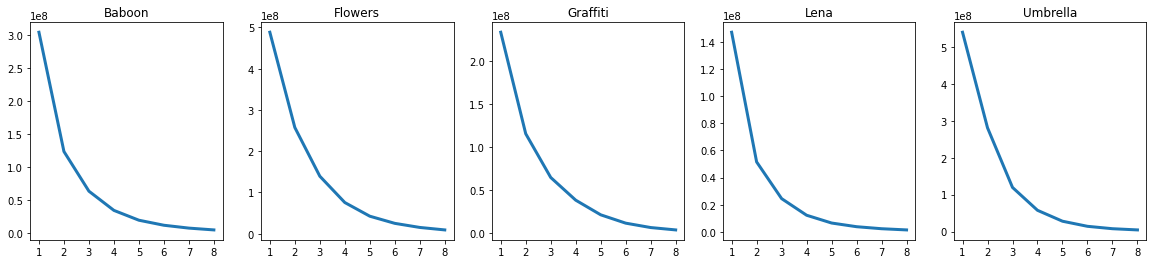

In [22]:
# k vs wcss plot to see elbow point
plt.figure(figsize=(20,4))
for k,title in enumerate(images_titles):
    elbow(final_result[final_result.index == title]["WCSS"].iloc[::-1], ks[::-1], k+1, title, optimum=None)

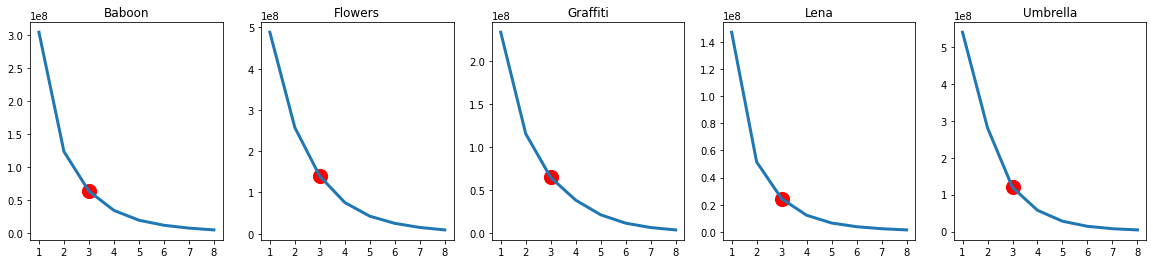

In [23]:
# optimum value is 3 for all, so k = 8(2**value) seems to best
plt.figure(figsize=(20,4))
for k,title in enumerate(images_titles):
    elbow(final_result[final_result.index == title]["WCSS"].iloc[::-1], ks[::-1], k+1, title, optimum=3)

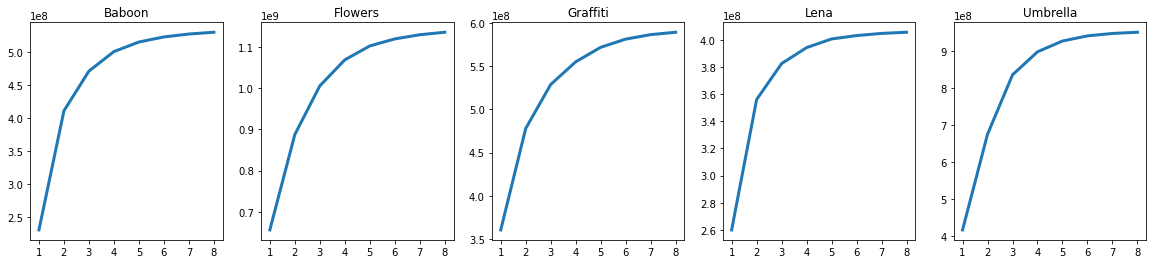

In [24]:
# k vs bcss plot
plt.figure(figsize=(20,4))
for k,title in enumerate(images_titles):
    elbow(final_result[final_result.index == title]["BCSS"].iloc[::-1], ks[::-1], k+1, title, optimum=None)

In [25]:
final_result[["k","Colors","WCSS","BCSS","Silhouette","Byte"]]

k                                             Colors  \
Name                                                               
Baboon    256  [silver, lightskyblue, chocolate, orangered, d...   
Baboon    128  [silver, chocolate, orangered, darkgoldenrod, ...   
Baboon     64  [silver, chocolate, orangered, darkgoldenrod, ...   
Baboon     32  [silver, orangered, darkgoldenrod, tomato, dim...   
Baboon     16  [cadetblue, darkolivegreen, chocolate, darkgra...   
Baboon      8  [darkgray, skyblue, tomato, darkkhaki, slategr...   
Baboon      4     [darkolivegreen, lightsteelblue, tomato, gray]   
Baboon      2                                [darkgray, dimgray]   
Flowers   256  [silver, chocolate, orangered, darkviolet, fir...   
Flowers   128  [silver, chocolate, firebrick, darkorchid, dar...   
Flowers    64  [chocolate, firebrick, darkorchid, darkgoldenr...   
Flowers    32  [mediumslateblue, forestgreen, darkslateblue, ...   
Flowers    16  [plum, darkolivegreen, purple, peru, mediumsla...   
Flowers     8  [darkolivegreen, purple, peru, darkslateblue, ...   
Flowers     4           [plum, darkslategray, slateblue, sienna]   
Flowers     2                          [darkslategray, darkgray]   
Graffiti  256  [silver, darksalmon, chocolate, firebrick, cor...   
Graffiti  128  [silver, darksalmon, chocolate, coral, tomato,...   
Graffiti   64  [silver, darksalmon, chocolate, darkslateblue,...   
Graffiti   32  [silver, darksalmon, chocolate, coral, black, ...   
Graffiti   16  [silver, darkolivegreen, chocolate, sienna, li...   
Graffiti    8  [silver, darkolivegreen, sienna, indianred, da...   
Graffiti    4        [silver, darkslategray, sandybrown, sienna]   
Graffiti    2                         [rosybrown, darkslategray]   
Lena      256  [silver, darksalmon, burlywood, darkslateblue,...   
Lena      128  [silver, darksalmon, burlywood, darkslateblue,...   
Lena       64  [silver, darksalmon, burlywood, brown, dimgray...   
Lena       32  [tan, darksalmon, sienna, indigo, lightslategr...   
Lena       16  [tan, darksalmon, indigo, burlywood, indianred...   
Lena        8  [darksalmon, sienna, indigo, indianred, brown,...   
Lena        4          [indianred, brown, burlywood, lightcoral]   
Lena        2                                [darksalmon, brown]   
Umbrella  256  [silver, darksalmon, limegreen, firebrick, dar...   
Umbrella  128  [silver, darksalmon, limegreen, firebrick, dar...   
Umbrella   64  [silver, limegreen, firebrick, darkgoldenrod, ...   
Umbrella   32  [silver, limegreen, firebrick, darkgoldenrod, ...   
Umbrella   16  [lightgray, darkgray, lightsteelblue, darkgold...   
Umbrella    8  [silver, firebrick, darkslateblue, rosybrown, ...   
Umbrella    4      [yellowgreen, steelblue, silver, saddlebrown]   
Umbrella    2                     [darkolivegreen, darkseagreen]   

                   WCSS            BCSS Silhouette    Byte  
Name                                                        
Baboon      4721707.755   529511813.711       0.37  152476  
Baboon      7450981.901    526822196.32      0.366  145790  
Baboon     11779396.972   522427166.041      0.375  135688  
Baboon     19387337.013   514735532.689      0.407  118459  
Baboon     34249384.006   500280364.365      0.409   95531  
Baboon     63295224.459   470789362.415      0.431   67339  
Baboon    123314156.507    410807823.23      0.466   38096  
Baboon    303681959.468   230846856.905      0.387   21911  
Flowers      9313285.97  1135207107.411      0.397  136552  
Flowers    15310337.663  1129181699.723      0.397  127561  
Flowers    25223194.684  1119062279.861      0.403  115226  
Flowers    42550603.065  1102053587.308      0.431   99106  
Flowers    75691894.214  1068334810.179      0.443   76884  
Flowers   139466564.706  1005327972.588      0.445   56173  
Flowers   257561121.151   887491256.196      0.486   31799  
Flowers   488348789.764    656369317.34      0.494   16938  
Graffiti    3981505.734     589533745.5      0.389  13734

In [26]:
# when k increase, wcss decrease
for title in images_titles:
    print(final_result[final_result.index == title][["k","WCSS"]].sort_values(by="WCSS",ascending=False))

          k           WCSS
Name                      
Baboon    2  303681959.468
Baboon    4  123314156.507
Baboon    8   63295224.459
Baboon   16   34249384.006
Baboon   32   19387337.013
Baboon   64   11779396.972
Baboon  128    7450981.901
Baboon  256    4721707.755
           k           WCSS
Name                       
Flowers    2  488348789.764
Flowers    4  257561121.151
Flowers    8  139466564.706
Flowers   16   75691894.214
Flowers   32   42550603.065
Flowers   64   25223194.684
Flowers  128   15310337.663
Flowers  256     9313285.97
            k           WCSS
Name                        
Graffiti    2  233127164.112
Graffiti    4  115467864.755
Graffiti    8   64776200.961
Graffiti   16   38467645.275
Graffiti   32   21494411.611
Graffiti   64   11823578.015
Graffiti  128    6727992.356
Graffiti  256    3981505.734
        k           WCSS
Name                    
Lena    2  146948298.644
Lena    4   51529655.586
Lena    8   24526519.912
Lena   16   12295667.403
Lena   32 

In [27]:
# when k increase, bcss increase
for title in images_titles:
    print(final_result[final_result.index == title][["k","BCSS"]].sort_values(by="BCSS",ascending=False))

          k           BCSS
Name                      
Baboon  256  529511813.711
Baboon  128   526822196.32
Baboon   64  522427166.041
Baboon   32  514735532.689
Baboon   16  500280364.365
Baboon    8  470789362.415
Baboon    4   410807823.23
Baboon    2  230846856.905
           k            BCSS
Name                        
Flowers  256  1135207107.411
Flowers  128  1129181699.723
Flowers   64  1119062279.861
Flowers   32  1102053587.308
Flowers   16  1068334810.179
Flowers    8  1005327972.588
Flowers    4   887491256.196
Flowers    2    656369317.34
            k           BCSS
Name                        
Graffiti  256    589533745.5
Graffiti  128   586781425.05
Graffiti   64  581556503.425
Graffiti   32  572079261.736
Graffiti   16  555229001.388
Graffiti    8  528953976.922
Graffiti    4  478009470.606
Graffiti    2  360378390.925
        k           BCSS
Name                    
Lena  256  405583545.288
Lena  128  404719350.165
Lena   64  403121883.598
Lena   32  400640413.464


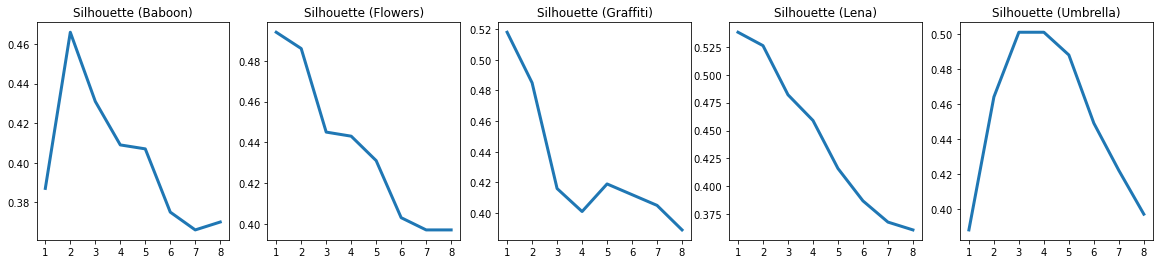

In [28]:
# silhouette scores
plt.figure(figsize=(20,4))
for k,title in enumerate(images_titles):
    exp_variance(final_result[final_result.index == title]["Silhouette"].iloc[::-1], ks[::-1], k+1, title)